In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:

% cd My Drive

% cd Colab Notebooks

/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks


In [0]:
#!unzip 2d_images.zip

In [0]:
#!unzip 2d_masks.zip

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


## Load and resize the images

In [3]:
IMAGE_LIB = '../datasets/io_images/img/'
MASK_LIB = '../datasets/io_images/msk/'
IMG_HEIGHT, IMG_WIDTH = 256, 256
SEED=42

In [4]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

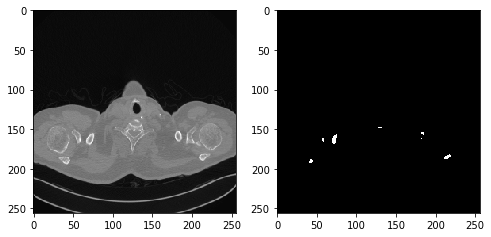

In [5]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [6]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

## Define and train model

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [8]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c4)
c5 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c5)
c6 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c6)
c7 = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c7)
c8 = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c8)
c9 = Conv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same')(l)


l = concatenate([UpSampling2D(size=(2,2))(c9), c8], axis=-1)

l = Conv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c7], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c6], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c5], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c4], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 1168        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [10]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

By using the same RNG seed in both calls to ImageDataGenerator, we should get images and masks that correspond to each other. Let's check this, to be safe.

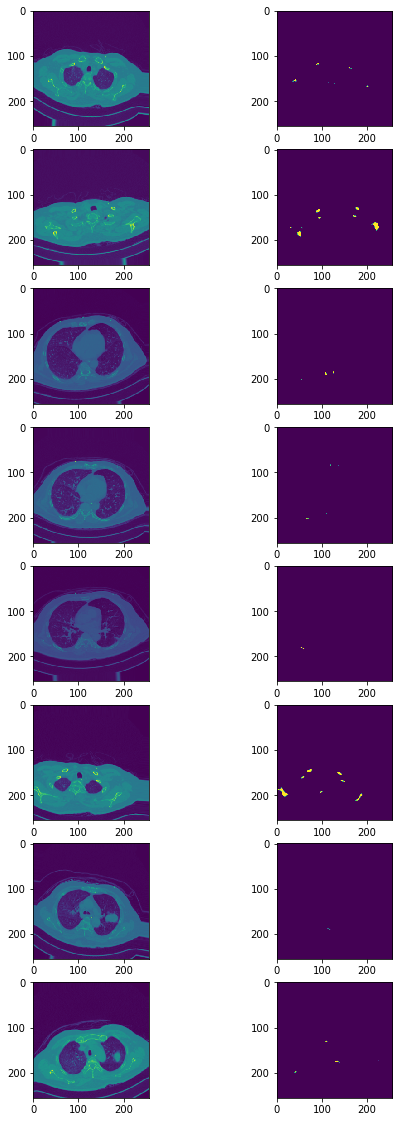

In [11]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [12]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [13]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [14]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=1,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
200/200 [==============================] - 575s 3s/step - loss: 0.0437 - dice_coef: 1.1579e-04 - val_loss: 0.0169 - val_dice_coef: 2.4163e-10
Epoch 2/10
200/200 [==============================] - 481s 2s/step - loss: 0.0185 - dice_coef: 8.6846e-07 - val_loss: 0.0169 - val_dice_coef: 2.4163e-10
Epoch 3/10
200/200 [==============================] - 407s 2s/step - loss: 0.0186 - dice_coef: 2.3052e-10 - val_loss: 0.0169 - val_dice_coef: 2.4163e-10
Epoch 4/10
200/200 [==============================] - 418s 2s/step - loss: 0.0189 - dice_coef: 2.1875e-10 - val_loss: 0.0169 - val_dice_coef: 2.4163e-10
Epoch 5/10
200/200 [==============================] - 413s 2s/step - loss: 0.0186 - dice_coef: 2.2752e-10 - val_loss: 0.0169 - val_dice_coef: 2.4163e-10
Epoch 6/10
200/200 [==============================] - 477s 2s/step - loss: 0.0186 - dice_coef: 2.2462e-10 - val_loss: 0.0169 - val_dice_coef: 2.4163e-10
Epoch 7/10
200/200 [==============================] - 451s 2s/step - loss: 0.0185 

## Evaluate

In [15]:
model.load_weights('lung.h5')

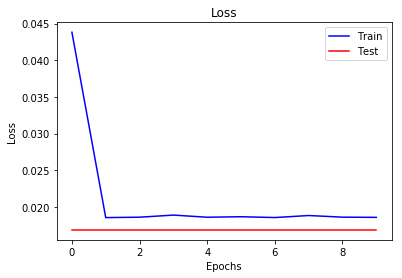

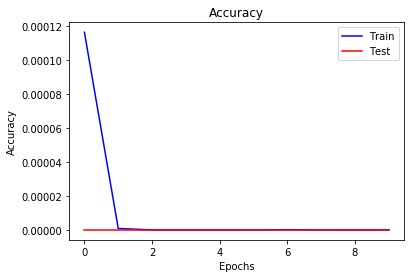

In [16]:
plt.plot(hist.history['loss'], color='b', label="Train")
plt.plot(hist.history['val_loss'], color='r', label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(hist.history['dice_coef'], color='b', label="Train")
plt.plot(hist.history['val_dice_coef'], color='r', label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

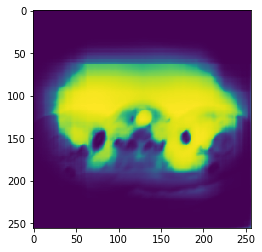

In [20]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0])

In [22]:
y_hat = model.predict(x_val)

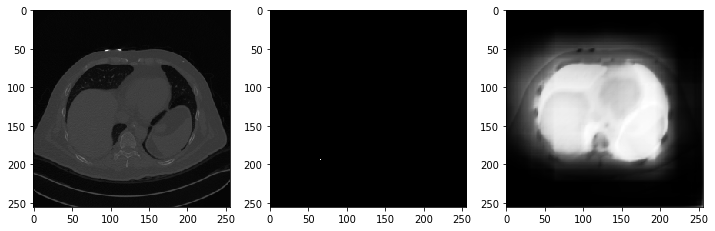

In [27]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[16,:,:,0], cmap='gray')
ax[1].imshow(y_val[16,:,:,0], cmap='gray')
ax[2].imshow(y_hat[16,:,:,0], cmap='gray')